In [5]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
from numba import vectorize, int64, float64

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [6]:
@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_log(x):
    c =  np.log(x)
    return c

@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_exp(x):
    c =  np.exp(x)
    return c

A = np.array([2, 5, 10, 3, 8])

logA = vec_log(A)
expA = vec_exp(A)

print(logA)
print(expA)

[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

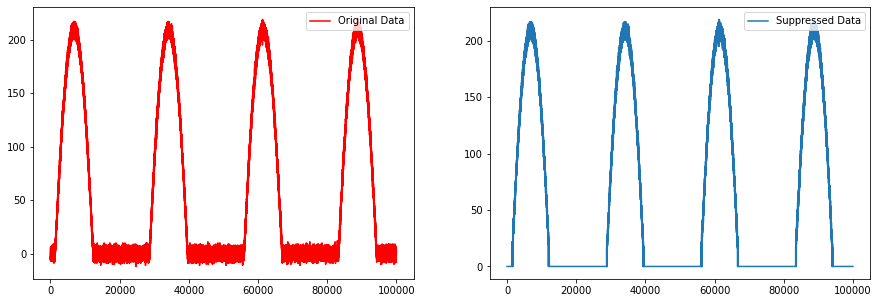

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

threshold = 15
n = 10**5
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

data_suppressed = np.copy(data)


@cuda.jit
def zero_suppression(array, array2, magnitude):
    pos = cuda.grid(1)
    if pos < array.size:
        if array[pos] < magnitude: 
          array2[pos] = 0


# Set the number of threads in a block
threadsperblock = 32 

# Calculate the number of thread blocks in the grid
blockspergrid = (data.size + (threadsperblock - 1)) // threadsperblock

# Now start the kernel
zero_suppression[blockspergrid, threadsperblock](data, data_suppressed ,threshold)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(data, label="Original Data", color='r')
ax[1].plot(data_suppressed, label="Suppressed Data")
ax[0].legend()
ax[1].legend()
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [8]:
x = np.random.rand(3,3)
y = np.random.rand(3,3)
a=0.3
c=0.1

# CUDA kernel
@cuda.jit
def sigmoid_kernel(array_out, x, y, a, c):
    row, column = cuda.grid(2)
    
    if row < array_out.shape[0] and column < array_out.shape[1]:
        array_out[row][column] = np.tanh(a*np.dot(x[row],y[column])+c)

array_out = np.zeros((len(x), len(y)))

# Configure the blocks
threadsperblock = (64, 16) 
blockspergrid_x = int(math.ceil(array_out.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(array_out.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

sigmoid_kernel[blockspergrid, threadsperblock](array_out, x, y, a, c)
print(array_out)

[[0.22408671 0.33611613 0.15777424]
 [0.16555752 0.18887329 0.12032271]
 [0.23898454 0.38320553 0.17348636]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [10]:
matrix = np.random.rand(256,256,256) * np.pi

@cuda.jit
def cos_matrix(io_array):
    x, y, z = cuda.grid(3)
        
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = np.cos(io_array[x][y][z])
        
        

cos_matrix[blockspergrid, threadsperblock](matrix)

print(matrix) 

[[[ 0.99438568  2.71961307  1.29213739 ...  0.68665273  2.26038447
    0.5391889 ]
  [-0.16547779  0.52540088  2.06466071 ...  2.20984752  0.78510296
    2.16284306]
  [ 0.99510988  3.12936309  2.92338161 ...  0.89480698  2.17335231
    0.03661276]
  ...
  [ 0.81203972  1.39593195  2.97389307 ...  2.98682909  0.17412571
    1.65616198]
  [ 2.41322081  1.58606739  0.56090904 ...  0.70746825  1.67069151
    2.12015309]
  [ 2.21937347  2.06934681  0.38888781 ...  1.96053391  0.19108303
    2.42627016]]

 [[-0.94785703  0.96822259  0.48307617 ...  1.83617941  3.02348418
    2.84332907]
  [ 0.74691624  2.71601302  1.33434888 ...  1.42466535  0.99347036
    2.18960768]
  [-0.08765599  0.60574124  0.70557148 ...  1.09103341  1.71547078
    0.42221312]
  ...
  [ 2.20803898  0.5810812   1.55441063 ...  1.41335429  2.4353761
    0.28603209]
  [ 0.53522932  1.9156999   0.87666537 ...  3.12507419  2.16694626
    1.98955001]
  [ 2.80876439  0.14085295  1.93635323 ...  2.22443611  0.01873996
    0.8

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [11]:
from __future__ import division
from numba import cuda
import numpy
import math


# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(50, size=(24, 12))
B = np.random.randint(50, size=(12, 22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (64, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)


print(C)

[[ 6628.  6846.  6867.  6526.  7414.  5946.  5800.  7931.  5989.  4050.
   6323.  5806.  6381.  4614.  7430.  5515.  6064.  5334.  5994.  6973.
   9538.  7453.]
 [ 6593.  5719.  6152.  6903.  5538.  5770.  5902.  7488.  5545.  3233.
   6591.  6723.  7856.  4309.  6579.  5917.  8504.  4615.  7174.  7639.
   8460.  8933.]
 [ 8351.  8347.  8833.  8399.  7755.  7935.  7763.  9288.  7436.  4651.
   8257.  7241.  9919.  6692. 10091.  7804.  9285.  5868.  7899. 10425.
  11421. 10681.]
 [ 4635.  4299.  7607.  5430.  5772.  4642.  3424.  5848.  3807.  3196.
   5202.  4006.  6312.  4020.  6109.  4592.  4803.  5211.  4832.  4550.
   7380.  6692.]
 [ 9944. 10444. 10888. 10076.  8669.  9499.  9877. 12775.  8187.  4172.
  10153.  7699. 11334.  6586.  9715.  9123.  8740.  7400.  9584.  9713.
  12298. 12368.]
 [ 6976.  5801.  7917.  6612.  6530.  6202.  5336.  8870.  5303.  3226.
   6372.  5608.  7855.  4943.  6355.  5292.  7180.  6660.  7631.  6485.
   9198.  8985.]
 [ 8238.  7397.  8846.  7651.  844